In [12]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from PIL import Image
from os.path import splitext


 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b>Loading Data & Data Preprocessing</b>

<p style="padding: 10px;color:black;font-size:40%;font-family: Times New Roman, Times, serif;">First using the OS library I'll upload the cityscapes pair images.</p>

In [13]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
path='../input/cityscapes-image-pairs'
def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endwith('png'):
                images.append(filename)
    return images
images=images_upload(path)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 2975/2975 [00:00<00:00, 676060.81it/s]


In [14]:
def convert_image_rgb(data):
    imgs=[]
    for i in tqdm(data):
        img = cv2.imread(i,cv2.COLOR_BGR2RGB)
        del i
        imgs.append(img)
    return imgs
img=convert_image_rgb(images)

100%|██████████| 6950/6950 [00:48<00:00, 143.61it/s]


<p style="padding: 10px;color:black;font-size:120%;font-family: Times New Roman, Times, serif;">Let us look at one of the images. It can be seen that the image contains both the real image and the mask, so the next task will be to distinguish between them. Randmoly has selected the following image.</p>

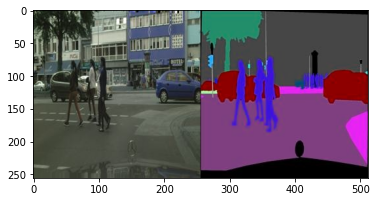

In [15]:
plt.imshow(img[np.random.randint(0,len(img))]);

<p style="padding: 10px;color:black;font-size:120%;font-family: Times New Roman, Times, serif;">Because the image shape is 512*256, it should be divided into two groups, real images and mask images, at 256 pixels on the x axis.</p>

In [16]:
def split_input_mask(data):
    inputs=[]
    mask=[]
    for i in data:
        a=i[:,:256]
        inputs.append(a)
        b=i[:,256:]
        mask.append(b)
    return inputs,mask
inputs,mask=split_input_mask(img)

In [17]:
del images
del img

<p style="padding: 10px;color:black;font-size:120%;font-family: Times New Roman, Times, serif;">In this section, I'll show a few images of the real images as well as a few images of the mask images after they've been separated.</p>

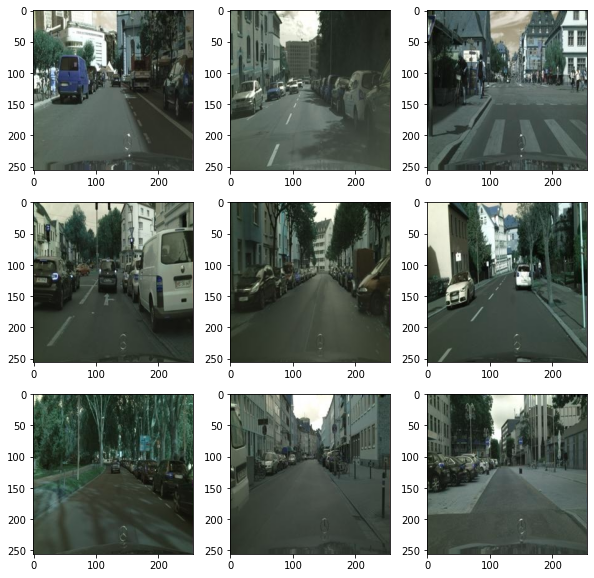

In [18]:
def show_images(data):
    plt.figure(figsize=(10,10))
    for i in range(9):
        idx=np.random.randint(0,len(data))
        plt.subplot(3,3,i+1)
        img=data[idx]
        plt.imshow(img)
show_images(inputs)

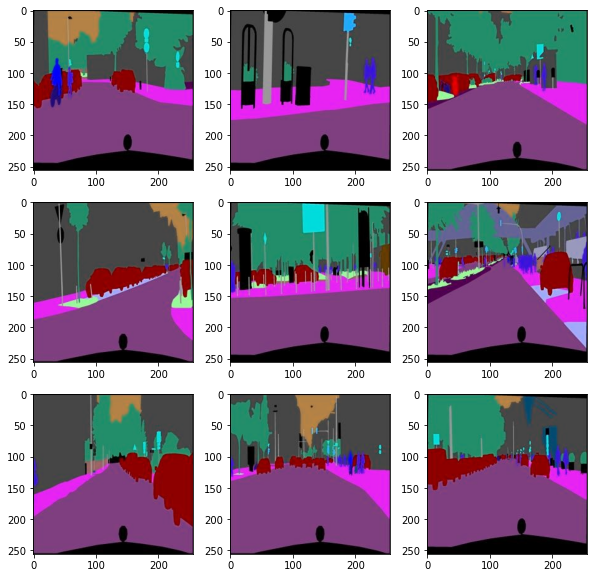

In [19]:
show_images(mask)

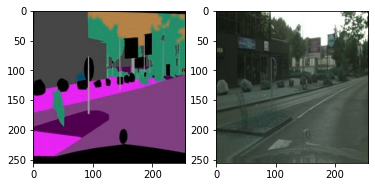

In [20]:
def images_compare(inputs,mask):
    idx_new=np.random.randint(0,len(mask))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(mask[idx_new])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(inputs[idx_new],cmap='gray')
    plt.show()
images_compare(inputs,mask)

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b>Labeling using K-means</b>

<p style="padding: 10px;color:black;font-size:40%;font-family: Times New Roman, Times, serif;">Although each pixel in these images is labeled, it was still necessary to separate the different colors to labels. K-means will be used to categorize these colored labels into ten different groups. This is a hyperparameter. The next few labeled images will be shown, followed by rescaling of the original image.</p>

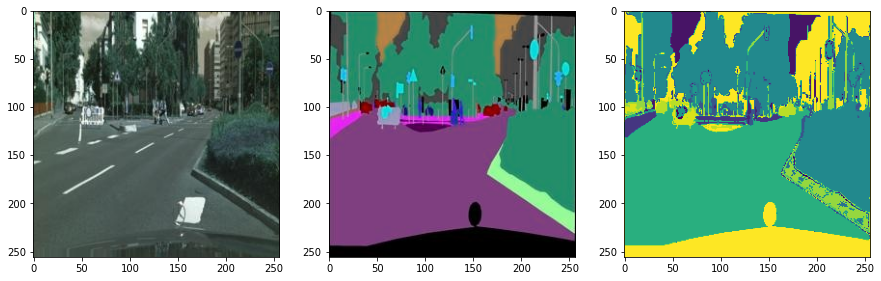

In [21]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
num_classes = 20
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)
label_class = label_model.predict(mask[10].reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(inputs[10]);
axes[1].imshow(mask[10]);
axes[2].imshow(label_class);

In [22]:
def new_labels(mask):
    num_items = 1000
    color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
    num_classes = 10
    label_model = KMeans(n_clusters = num_classes)
    label_model.fit(color_array)
    labels=[]
    for i in tqdm(range(len(mask))):
        label_class = label_model.predict(mask[i].reshape(-1,3)).reshape(256,256)
        labels.append(label_class)
    return labels


In [23]:
labels=new_labels(mask)
idx=np.random.randint(0,len(labels))
classes,freq=np.unique(labels[idx],return_counts=True)
print(f'number of classes :{len(classes)}')

100%|██████████| 6950/6950 [00:27<00:00, 253.28it/s]

number of classes :10


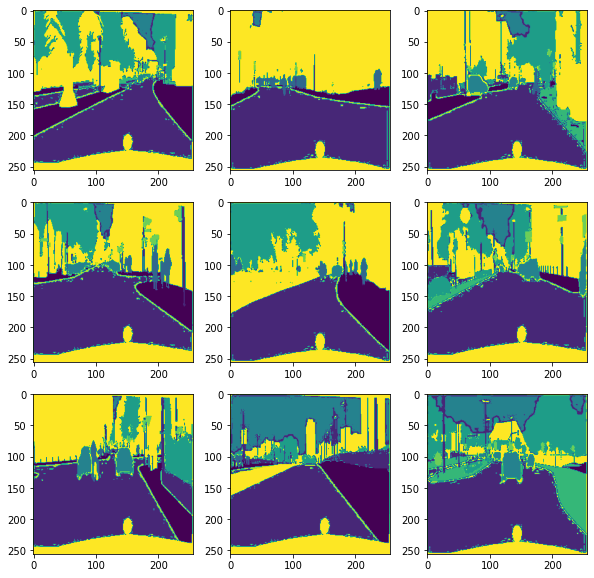

In [24]:
plt.figure(figsize=(10,10))
for i in range(9):
        plt.subplot(3,3,i+1)
        im=labels[i]
        plt.imshow(im)
# plt.imshow(a)

In [25]:
def rescale(data):
    rescaled=[]
    for i in tqdm(data):
        img=tf.image.convert_image_dtype(i, tf.float32)
        del i
        rescaled.append(img)
    return rescaled

In [26]:
rescaled_input=rescale(inputs)


100%|██████████| 6950/6950 [00:05<00:00, 1164.68it/s]


 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b>Buliding the model</b>

<p style="padding: 10px;color:black;font-size:40%;font-family: Times New Roman, Times, serif;"> Here I'm using UNet since the position of the object is crucial for this task. The feature map is upsampled to the size of the original input image using a transposed convolution layer that preserves the spatial information. It also includes skip connections, which help to keep information that would otherwise be lost during encoding. This model is kind of mini-VGG. </p>

In [27]:
def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(
        inputs)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(
        x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='softmax', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [28]:
mymodel=build_model(classes=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

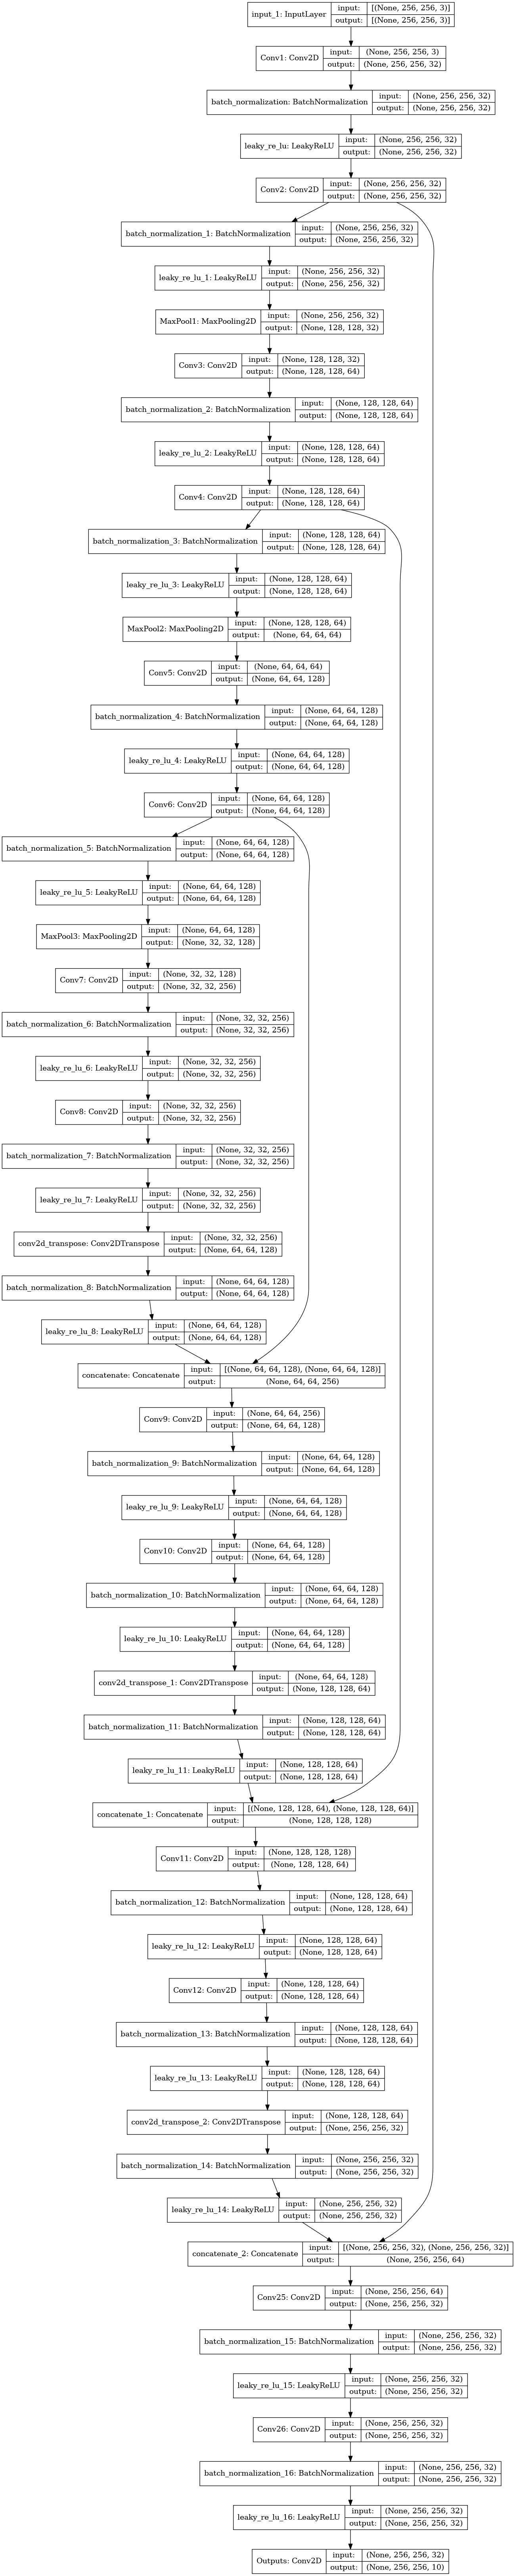

In [29]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(mymodel, to_file=img_file, show_shapes=True, show_layer_names=True)

In [30]:
del inputs

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b>Training the model</b>

<p style="padding: 10px;color:black;font-size:40%;font-family: Times New Roman, Times, serif;"> The data is divided into train and test segments, with each segment accounting for 80% and 20% of the total. To prevent RAM memory from crashing, I'm using 1300 images. Because the model's output employs 'softmax' activation layer, the loss function is sparse categorical crossentropy. Next, I'm going to use argmax to return the index with the highest value, and then I'm going to make some predictions for the test.</p>

In [31]:
def split_data(x,y,test_size=0.2):
    x1=np.array(x)
    del x
    y1=np.array(y)
    del y
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=test_size)
    return  x_train, x_test, y_train, y_test

In [32]:
 x_train, x_test, y_train, y_test=split_data(rescaled_input[:1300],labels[:1300],test_size=0.2)

  

In [33]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list


In [34]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['acc'])
hist=mymodel.fit(x_train,y_train,batch_size=16,epochs=200,callbacks=callbacks())

Epoch 1/200
65/65 [==============================] - 21s 175ms/step - loss: 1.2157 - acc: 0.6081

Epoch 00001: loss improved from inf to 1.21574, saving model to seg_model.h5
Epoch 2/200
65/65 [==============================] - 11s 175ms/step - loss: 0.9446 - acc: 0.6854

Epoch 00002: loss improved from 1.21574 to 0.94458, saving model to seg_model.h5
Epoch 3/200
65/65 [==============================] - 11s 175ms/step - loss: 0.8520 - acc: 0.7138

Epoch 00003: loss improved from 0.94458 to 0.85198, saving model to seg_model.h5
Epoch 4/200
65/65 [==============================] - 11s 175ms/step - loss: 0.7935 - acc: 0.7327

Epoch 00004: loss improved from 0.85198 to 0.79346, saving model to seg_model.h5
Epoch 5/200
65/65 [==============================] - 11s 175ms/step - loss: 0.7476 - acc: 0.7476

Epoch 00005: loss improved from 0.79346 to 0.74757, saving model to seg_model.h5
Epoch 6/200
65/65 [==============================] - 11s 175ms/step - loss: 0.7116 - acc: 0.7607

Epoch 00006

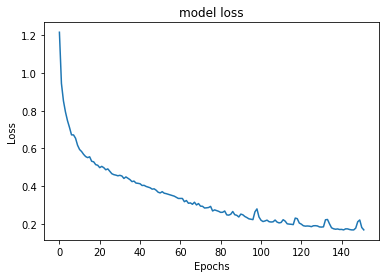

In [35]:
plt.plot(hist.history['loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

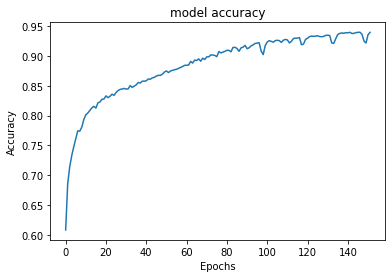

In [36]:
plt.plot(hist.history["acc"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [37]:
pred=mymodel.predict(x_test)
y_pred=tf.argmax(pred,axis=-1)

In [38]:

def show_predications(x_test,y_test,y_pred):
    idx=np.random.randint(0,len(y_pred))
    fig, axes = plt.subplots(1,3,figsize=(10,10))
    axes[0].imshow(x_test[idx])
    axes[0].set_title("original")
    axes[1].imshow(y_test[idx])
    axes[1].set_title("mask")
    axes[2].imshow(y_pred[idx])
    axes[2].set_title("predicated")
 


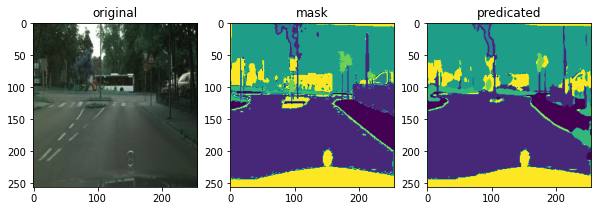

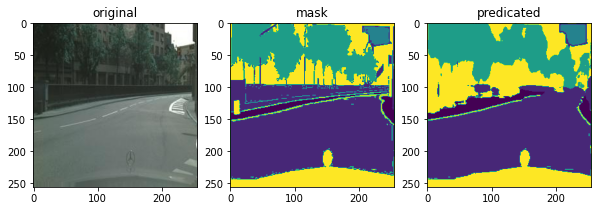

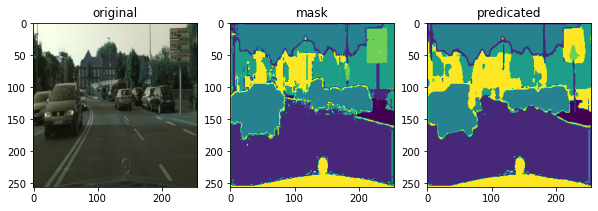

In [39]:
for i in range(3):
    show_predications(x_test,y_test,y_pred)

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b>Conclusions</b>

<p style="padding: 10px;color:black;font-size:40%;font-family: Times New Roman, Times, serif;">
Despite the fact that the results are not amazing, they are not so bad. More layers, as well as augmentations and different class clustering, are required for even better results.</p>